# Configure Settings

In [1]:
# import all packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import pytz
import collections
from scipy import stats

In [2]:
# configure DataFrame display settings
pd.options.display.max_columns = None

In [3]:
# configure seaborn settings
sns.set(style='whitegrid', font_scale=1.4)

In [4]:
# seed the pseudorandom number generator
np.random.seed(42)

# Load the Pre-processed Data

The pre-processed data file is too large to store on github.  The file is created, stored, and loaded locally on my machine during my analysis.  

Anyone else using this code should download a copy of the data file from my google drive.  A backup copy of the pre-processed data file (version uploaded on 1/21/2019), as well as copies of the input weather and flight data files, can be downloaded here: https://drive.google.com/open?id=1PkbeFC4E2Vea67YqzfooeZacI9eKd9-P  
Note that, after downloading the pre-processed data file, the filepath should be updated in the code below.

In [5]:
# set the input directory
dir_in = 'C:/Users/Jonathon.Poage/Desktop/Springboard/Capstone_Documentation/Project_1/Data_Files/preprocessed_data/'

# set the input filepath
filename_in = 'merged_flight_weather_data_preprocessed.csv'
filepath_in = dir_in + filename_in

In [6]:
# columns to parse as dates
ts_cols_in = ['crs_dep_ts',
              'dep_ts',
              'wheels_off_ts',
              'valid']

# set dtype for each column
dict_dtype_in = {'QUARTER':np.int8,
                 'OP_UNIQUE_CARRIER':'category',
                 'OP_CARRIER_FL_NUM':np.int16,
                 'ORIGIN':'category',
                 'DEST':'category',
                 'DEP_TIME_BLK':'category',
                 'origin_timezone':'category',
                 'station':'category',
                 'skyc1':'category',
                 'skyc2':'category',
                 'skyc3':'category',
                 'skyc4':'category',
                 'skyl1':np.float64,
                 'skyl2':np.float64,
                 'skyl3':np.float64,
                 'skyl4':np.float64,
                 'wxcodes':'category',
                 'station_timezone':'category'}

In [7]:
# load the data -- should take about 1 minute
df = pd.read_csv(filepath_in,
                 parse_dates=ts_cols_in,
                 dtype=dict_dtype_in,
                 low_memory=False)

# Exploratory Data Analysis (EDA)

## Mean Departure Delay

This section tests whether the mean departure delay is different from 0 minutes.

In [8]:
# sample mean and standard deviation
mean_d = np.mean(df.DEP_DELAY)
sample_std_d = np.std(df.DEP_DELAY, ddof=1)

# estimate the standard error of the mean
se_mean_d = sample_std_d / np.sqrt(df.DEP_DELAY.count())

In [9]:
# p-value for the sample mean
p_value = stats.norm.sf(mean_d, loc=0, scale=se_mean_d)

print('mean =', mean_d)
print('Standard Error =', se_mean_d)
print('p-value =', p_value)

mean = 10.5476638682
Standard Error = 0.0224576923933
p-value = 0.0


## Departure Delays Between Airports and Airlines

### $\chi^2$ Tests of Independence -- Contingency Tables

This section tests whether there is an association between the airports and the departure delays.  It also tests whether there is an association between the airline carriers and the departure delays. In each case, proportionate stratified random samples are drawn from the pre-processed dataset.  

In [10]:
# define the octile bins
octile_bins = [df.DEP_DELAY.quantile(i/8) for i in range(9)]
    
# initialize empty lists of index arrays
rs_inds_airports_list = []
rs_inds_airlines_list = []

# loop over airport codes
for a in df.ORIGIN.unique():
    df_d = df.DEP_DELAY[df.ORIGIN == a]
    inds = np.random.choice(df_d.index, size=int(df_d.count() / 11), replace=False)
    rs_inds_airports_list.append(inds)
    
# loop over airline carrier codes
for a in df.OP_UNIQUE_CARRIER.unique():
    df_d = df.DEP_DELAY[df.OP_UNIQUE_CARRIER == a]
    inds = np.random.choice(df_d.index, size=int(df_d.count() / 11), replace=False)
    rs_inds_airlines_list.append(inds)
    
# concatenate the arrays of indices
rs_inds_airports = np.concatenate(rs_inds_airports_list)
rs_inds_airlines = np.concatenate(rs_inds_airlines_list)
    
# make dataframes with the random samples
df_ap = df.loc[rs_inds_airports]
df_al = df.loc[rs_inds_airlines]
    
# bin the delays
df_ap['delay_bin'] = pd.cut(df_ap.DEP_DELAY, bins=octile_bins, include_lowest=True)
df_al['delay_bin'] = pd.cut(df_al.DEP_DELAY, bins=octile_bins, include_lowest=True)

# create the contingency tables for airports and airline carriers
df_ct_airports = df_ap.DEP_DELAY.groupby([df_ap.ORIGIN, df_ap.delay_bin]).count().sort_index().unstack()
df_ct_airlines = df_al.DEP_DELAY.groupby([df_al.OP_UNIQUE_CARRIER, df_al.delay_bin]).count().sort_index().unstack()

In [11]:
# evaluate the chi-square statistics and p-values
chi2_airports, p_airports, dof_airports, e_airports = stats.chi2_contingency(df_ct_airports)
chi2_airlines, p_airlines, dof_airlines, e_airlines = stats.chi2_contingency(df_ct_airlines)

# print the results
print('Airports: chi^2 = %.2f   p-value = %f' % (chi2_airports, p_airports))
print('Airlines: chi^2 = %.2f   p-value = %f' % (chi2_airlines, p_airlines))

Airports: chi^2 = 11674.42   p-value = 0.000000
Airlines: chi^2 = 24764.96   p-value = 0.000000


### $\chi^2$ Goodness of Fit Tests

A chi-square goodness of fit test is performed for each stratified random sample, to determine whether each distribution of delays has a similar shape to the total distribution of delays. 

In [12]:
# bin the departure delays into intervals
delay_bins = pd.cut(df.DEP_DELAY, bins=octile_bins, include_lowest=True)

# find the relative frequency of delays in each bin
rel_freq_delays = df.DEP_DELAY.groupby(delay_bins).count().sort_index() / df.DEP_DELAY.count()

# loop over airport codes
print('Airport Results\n')
for a in df.ORIGIN.unique():
    obs = df_ct_airports.loc[a]
    exp = rel_freq_delays * np.sum(obs)
    chi2, p = stats.chisquare(obs, exp)
    print('%s |  chi^2 = %8.2f |  p-value = %f' % (a, chi2, p))
    
# loop over airline carrier codes
print('\nAirline Carrier Results\n')
for a in df.OP_UNIQUE_CARRIER.unique():
    obs = df_ct_airlines.loc[a]
    exp = rel_freq_delays * np.sum(obs)
    chi2, p = stats.chisquare(obs, exp)
    print('%s |  chi^2 = %8.2f |  p-value = %f' % (a, chi2, p))

Airport Results

ATL |  chi^2 =  6912.99 |  p-value = 0.000000
LAX |  chi^2 =   819.44 |  p-value = 0.000000
ORD |  chi^2 =   254.56 |  p-value = 0.000000
DFW |  chi^2 =   727.63 |  p-value = 0.000000
JFK |  chi^2 =   656.79 |  p-value = 0.000000
DEN |  chi^2 =   141.43 |  p-value = 0.000000
SFO |  chi^2 =   455.53 |  p-value = 0.000000
LAS |  chi^2 =   282.08 |  p-value = 0.000000
SEA |  chi^2 =  1175.37 |  p-value = 0.000000
MIA |  chi^2 =   256.41 |  p-value = 0.000000

Airline Carrier Results

NK |  chi^2 =  2441.47 |  p-value = 0.000000
F9 |  chi^2 =  1472.96 |  p-value = 0.000000
DL |  chi^2 =  6123.10 |  p-value = 0.000000
AA |  chi^2 =  1292.19 |  p-value = 0.000000
UA |  chi^2 =  1029.71 |  p-value = 0.000000
AS |  chi^2 =  4204.05 |  p-value = 0.000000
WN |  chi^2 =  6739.38 |  p-value = 0.000000
B6 |  chi^2 =  1477.07 |  p-value = 0.000000


### Confidence Intervals of the Means

This section evaluates the 95 % Confidence Intervals for the Mean departure delays.  The confidence intervals are given for the stratified random samples from the previous sections.  

In [13]:
# function to get the Confidence Interval of the mean
def get_CI(sample, alpha=0.95, dof=1):
    """ This function takes a series as input.
    It also optionally takes a significance level
    and degrees of freedom as input.
    It assumes the input series has no missing values.
    This function returns a tuple with the 
    bounds of the confidence interval."""
    
    # find the mean and SE of the mean
    mean = np.mean(sample)
    SE = np.std(sample, ddof=dof) / np.sqrt(len(sample))
    
    # get the confidence interval
    CI = stats.norm.interval(alpha, loc=mean, scale=SE)
    return CI

In [14]:
# get the CIs for airports
df_CI_airports = df_ap.DEP_DELAY.groupby(df_ap.ORIGIN).agg(get_CI).reset_index()
df_CI_airports.columns = ['Airport','CI']

# get the sample means and margins of error for airports
df_CI_airports['Sample_Mean'] = df_CI_airports.CI.apply(np.mean)
df_CI_airports['Margin_of_Error'] = df_CI_airports.CI.apply(lambda x: (x[1] - x[0]) / 2)

# get the CIs for airlines
df_CI_airlines = df_al.DEP_DELAY.groupby(df_al.OP_UNIQUE_CARRIER).agg(get_CI).reset_index()
df_CI_airlines.columns = ['Airline','CI']

# get the sample means and margins of error for airlines
df_CI_airlines['Sample_Mean'] = df_CI_airlines.CI.apply(np.mean)
df_CI_airlines['Margin_of_Error'] = df_CI_airlines.CI.apply(lambda x: (x[1] - x[0]) / 2)

In [15]:
# sort by sample means
df_CI_airports = df_CI_airports.sort_values('Sample_Mean').reset_index(drop=True)
df_CI_airlines = df_CI_airlines.sort_values('Sample_Mean').reset_index(drop=True)

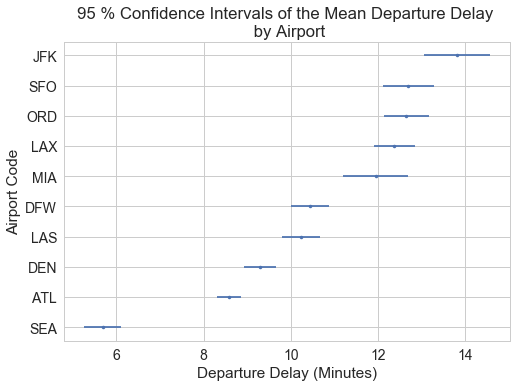

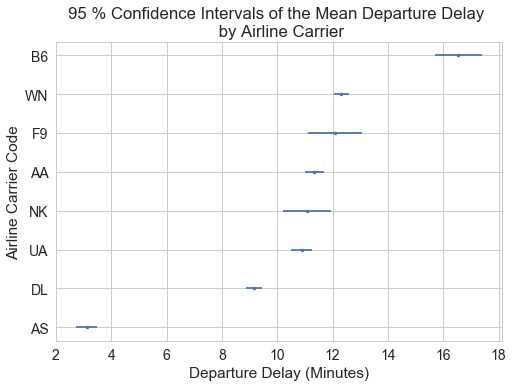

In [16]:
# plot the CIs for airports
plt.errorbar(x=df_CI_airports.Sample_Mean, y=df_CI_airports.index, xerr=df_CI_airports.Margin_of_Error, marker='.', linestyle='none')
plt.yticks(df_CI_airports.index, df_CI_airports.Airport)
plt.xlabel('Departure Delay (Minutes)')
plt.ylabel('Airport Code')
plt.title('95 % Confidence Intervals of the Mean Departure Delay \n by Airport')
plt.show()

# plot the CIs for airlines
plt.errorbar(x=df_CI_airlines.Sample_Mean, y=df_CI_airlines.index, xerr=df_CI_airlines.Margin_of_Error, marker='.', linestyle='none')
plt.yticks(df_CI_airlines.index, df_CI_airlines.Airline)
plt.xlabel('Departure Delay (Minutes)')
plt.ylabel('Airline Carrier Code')
plt.title('95 % Confidence Intervals of the Mean Departure Delay \n by Airline Carrier')
plt.show()

## Departure Delays vs Weather Variables

This section evaluates the Pearson correlation coefficients between departure delays and various weather variables.  

In [17]:
# filter the dataframe to compare delays with weather variables
df_w = df[((df.CARRIER_DELAY == 0) | df.CARRIER_DELAY.isnull())
        & ((df.WEATHER_DELAY == 0) | df.WEATHER_DELAY.isnull())
        & ((df.NAS_DELAY == 0) | df.NAS_DELAY.isnull())
        & ((df.SECURITY_DELAY == 0) | df.SECURITY_DELAY.isnull())
        & ((df.LATE_AIRCRAFT_DELAY == 0) | df.LATE_AIRCRAFT_DELAY.isnull())]

In [18]:
# list of numeric weather variable column labels
numeric_weather_cols = ['tmpf',
                        'dwpf',
                        'relh',
                       # 'drct',   excluding wind direction because runway direction varies
                        'sknt',
                        'p01i',
                        'alti',
                        'mslp',
                        'vsby',
                        'gust',
                        'skyl1',
                        'skyl2',
                        'skyl3',
                        'skyl4']

corr_delay_weather = df_w[['DEP_DELAY'] + numeric_weather_cols].corr()
corr_delay_weather

,DEP_DELAY,tmpf,dwpf,relh,sknt,p01i,alti,mslp,vsby,gust,skyl1,skyl2,skyl3,skyl4
DEP_DELAY,1.000000,0.025411,0.009435,-0.011335,0.031195,0.032427,-0.019235,-0.016698,-0.025909,0.013958,-0.035815,-0.027502,-0.032507,-0.035256
tmpf,0.025411,1.000000,0.610843,-0.306688,-0.031026,-0.028811,-0.217189,-0.334185,0.156292,-0.270423,0.023419,0.159016,0.255120,0.205754
dwpf,0.009435,0.610843,1.000000,0.519327,-0.071794,0.054806,-0.152110,-0.146095,-0.089932,-0.208900,-0.355735,-0.175212,-0.058894,0.074320
relh,-0.011335,-0.306688,0.519327,1.000000,-0.093852,0.130604,-0.016337,0.109172,-0.376263,0.022924,-0.494450,-0.467095,-0.458967,-0.210094
sknt,0.031195,-0.031026,-0.071794,-0.093852,1.000000,0.011117,-0.206278,-0.193519,0.060841,0.873201,-0.116230,-0.040001,-0.039992,0.027974
p01i,0.032427,-0.028811,0.054806,0.130604,0.011117,1.000000,-0.059077,-0.043095,-0.225505,0.036985,-0.081105,-0.126955,-0.167406,-0.068690
alti,-0.019235,-0.217189,-0.152110,-0.016337,-0.206278,-0.059077,1.000000,0.956807,0.075068,-0.246851,0.136712,0.107360,0.128678,0.077825
mslp,-0.016698,-0.334185,-0.146095,0.109172,-0.193519,-0.043095,0.956807,1.000000,0.033225,-0.221216,0.089610,0.047948,0.057240,0.086367
vsby,-0.025909,0.156292,-0.089932,-0.376263,0.060841,-0.225505,0.075068,0.033225,1.000000,-0.064919,0.248260,0.289337,0.341781,0.200392
gust,0.013958,-0.270423,-0.208900,0.022924,0.873201,0.036985,-0.246851,-0.221216,-0.064919,1.000000,-0.049186,-0.069560,-0.094663,-0.141294


### Hypothesis tests

It is possible to test the significance of the Pearson correlation coefficients between departure delays and each weather variable using t-tests.  This approach is not entirely appropriate, because the weather variables are predictors of departure delays. It is more appropriate to use regression models and Analysis of Variance (ANOVA). The analysis of the relationship between weather variables and departure delays is beyond the scope of the EDA.  The final analysis will include regression models and F-tests.   

The following tasks may be completed after the Machine Learning Unit:
1. Perform a multiple regression.  Model departure delay as a function of several weather variables.
2. Perform a linear regression between departure delays and each individual weather variable sequentially.  In each case, the other weather variables will be held fixed under certain conditions in order to best isolate the variation in delays with respect to the chosen weather variable.  